In [11]:
import librosa as librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline
import librosa.display
from IPython.display import Audio
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import splitfolders
import skimage.io

### Load sample audio file and display the raw waveform (time domain)

The sampled audio is returned as a numpy array (time series) and has  (122352,)  number of samples
The 10 randomly picked consequitive samples of the audio are:  [ 0.01115187  0.00990775  0.00685935  0.00221485 -0.00189153 -0.00307884
 -0.00109208  0.00213019  0.00434993  0.00441293]


C:\Users\nidul\AppData\Local\Temp\ipykernel_9736\3973446443.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, sr= sr, x_axis='s')


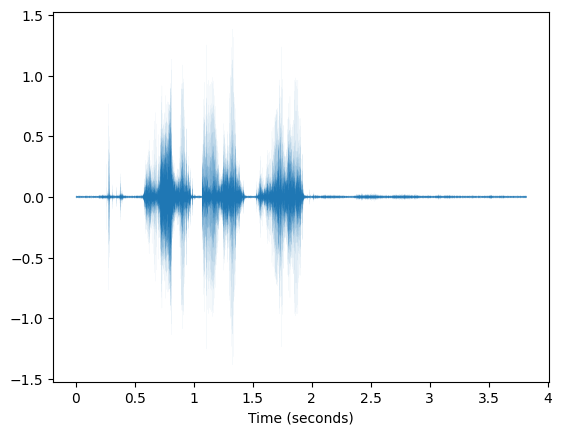

In [4]:
y, sr = librosa.load('ROBOVOX_SP_CUP_2024/single-channel/enrollment/spk_10/spk_10-10_21_0_0_d2_ch5.wav', sr=32000)
librosa.display.waveshow(y, sr= sr, x_axis='s')
print("The sampled audio is returned as a numpy array (time series) and has ", y.shape, " number of samples")
print("The 10 randomly picked consequitive samples of the audio are: ", y[3000:3010])

In [5]:
# Hear the audio
Audio('ROBOVOX_SP_CUP_2024/single-channel/enrollment/spk_10/spk_10-10_21_0_0_d2_ch5.wav')

### Find the Spectrogram. 
To understand spectrogram, we first need to know what is a spectrum. The Spectrum is the set of frequencies that make up a specific signal. The lowest frequency in a signal called the fundamental frequency. Frequencies that are whole number multiples of the fundamental frequency are known as harmonics. The spectrum of a signal (especially of a non-periodic) changes with time. Therefore, the common approach is to find the spectrum for small fixed section of a signal at a time. This is repeated until we have traversed all of sampled signal. The spectrum for all of the individual sections of a signal are stacked together and that gives us the spectrogram. 

Another key thing to remember is that spectrum of a signal is found by taking the Fourier Transform of the signal in a time domain. The approach that is normally taken in to divide the sampled signal into equal parts (as mentioned above) and take the Fourier Transform of each part individually. This is called STFT. Thefore, when we want to take the STFT of a signal, we need to specify how many samples we should consider at a time. 

Spectrogram is represented as a matrix. 

Refer to the sources below to learn more about the spectrograms.
Important concepts to understand from the references below are Spectrum, Windowing, Short Time Fourier Transform (STFT)

https://www.phon.ucl.ac.uk/courses/spsci/acoustics/week1-10.pdf
https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf
https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504



In [6]:
# Size of the Fast Fourier Transform (FFT), which will also be used as the window length
n_fft=1024

# Step or stride between windows. If the step is smaller than the window length, the windows will overlap
hop_length=320

# Specify the window type for FFT/STFT
window_type ='hann'

# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type)) ** 2

print("The shape of spectrogram_librosa is: ", spectrogram_librosa.shape)
print("The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])")
print("The frame size that we have specified is the number of samples to consider for the STFT. In our case, it is equal to the n_fft",n_fft, " samples")
print("The number of frames depends on the total length of the sampled signal, the number of samples in each frame and the hop length.")

The shape of spectrogram_librosa is:  (513, 383)
The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])
The frame size that we have specified is the number of samples to consider for the STFT. In our case, it is equal to the n_fft 1024  samples
The number of frames depends on the total length of the sampled signal, the number of samples in each frame and the hop length.


### Display the spectrogram

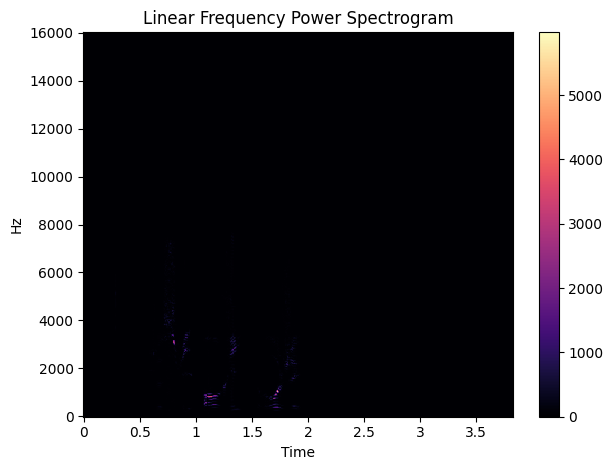

In [7]:
librosa.display.specshow(spectrogram_librosa, sr=sr, x_axis='time', y_axis='linear',hop_length=hop_length)
plt.title('Linear Frequency Power Spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

### Transform the spectrogram output to a logarithmic scale by transforming the amplitude to decibels and frequency to a mel scale

Reference: https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/audio_processing/spectrogram.html

The change of scale is done so that we can actually get a spectrogram from which we can visually infer some meaningful information. The spectrogram above is hard to read as our hearing range is limited to a small set of frequecies and amplitudes. 

How humans perceive amplitude of a sound? Humans perceive amplitude of a sound as its loudness. We hear loudness logarithmically rather than linearly. This is accounted for with a Decibel scale. 0dB is silence. 10 dB is 10 times louder than 0 dB, 20 dB is 100 times louder and 30 dB is 1000 times louder and so on . .

How humans perceive the frequencies in a sound? We as humans perceive perceive frequrncies on a logarithmic scale, rather than a linear scale. . .  Meaning we can easily tell the differences between lower frequencies (such as between 100Hz and 200Hz) but we can hardly tell the differences between higher frequencies (such as 10000Hz and 100100Hz). In both cases, the difference in frequency is 100Hz but to a human ear 200Hz appears farther apart than 100Hz. However, looking at it differently, in the 100Hz-200Hz pair, the second frequency is double the first frequency, whereas in the 10000Hz-100100Hz pair, the second frequency is only 1% more than the first one. Therfore, we can say that we hear them on a logarithmic scale rather than a linear scale. This gave rise to a Mel scale.

Therfore, it is important for us to use a logarithmic scale via the Mel Scale (for frequency) and the Decibel scale (for amplitude) when dealing with Frequencies and Amplitudes for an audio input.

#### Mel Spectrogram

https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html

The mel scale is a non-linear transformation of frequency scale based on the perception of pitches. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as being equidistant. 

In machine learning applications involving speech and audio, we typically want to represent the power spectrogram in the mel scale domain. We do that by applying a bank of overlapping triangular filters (called mel filter bank) that compute the energy of the spectrum in each band. 

The shape of the Mel spectrogram is [number of mel bands x (frame_size/2) + 1, where frame_size is the number of FFT components (n_fft)



The shape of mel spectrogram is:  (64, 383)


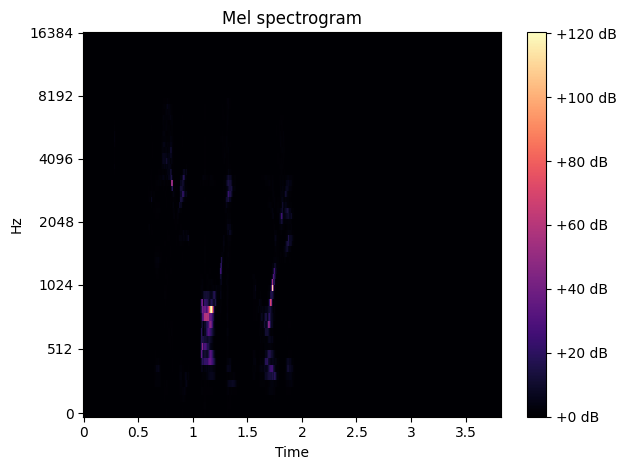

In [8]:
mel_bins = 64 # Number of mel bands
fmin = 0
fmax= None
Mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels = mel_bins, power=2.0)
print("The shape of mel spectrogram is: ", Mel_spectrogram.shape)

librosa.display.specshow(Mel_spectrogram, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()


#### Log Mel Spectrogram
Move from power (mel) spectrum and apply log and move amplitude to a log scale (decibels). While doing so we will also normalize the spectrogram so that its maximum represent the 0 dB point.

https://stackoverflow.com/questions/52432731/store-the-spectrogram-as-image-in-python/52683474 - How to save the figure in the working directory.

https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349 - if the desire is to save the data in the spectrogram (not the image itself)

The shape of Log Mel spectrogram is:  (64, 383)


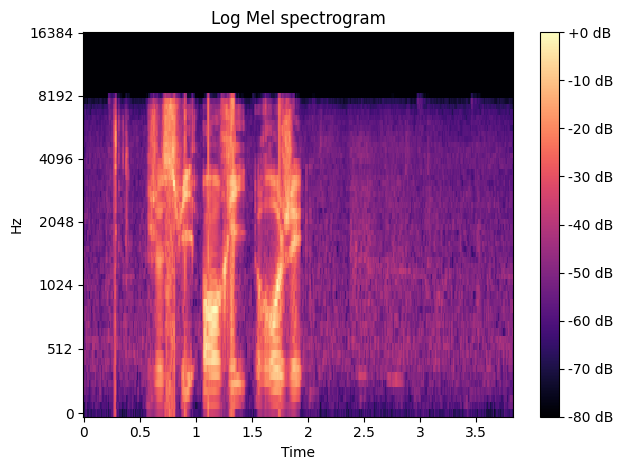

In [9]:
mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
print("The shape of Log Mel spectrogram is: ", mel_spectrogram_db.shape)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel spectrogram')
plt.tight_layout()
plt.show()

##### Save the plot in a local directory

wrote file out.png


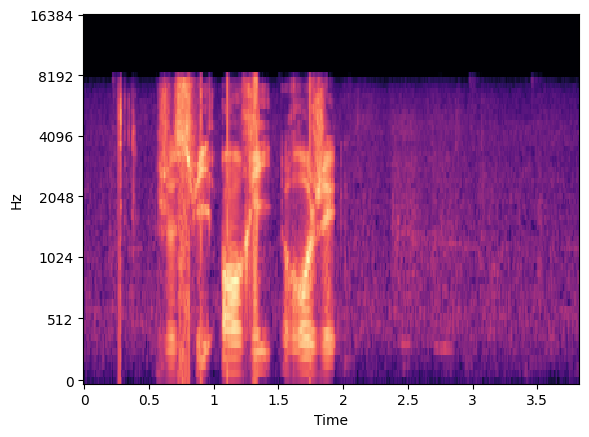

In [12]:
##### TO SAVE THE PLOT #####
# METHOD 1
fig = plt.Figure(figsize=(8,8), dpi=128, frameon=False)
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
fig.savefig('./'+str(1)+'.png', bbox_inches='tight', pad_inches=0, dpi=128)


# METHOD 2
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(mel_spectrogram_db, out):

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mel_spectrogram_db , 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

# convert to PNG
out = 'out.png'
spectrogram_image(mel_spectrogram_db, out=out)
print('wrote file', out)

##### Save the data in the spectrogram, rather than a plot (image)

Using numpy.save(): https://numpy.org/doc/stable/reference/generated/numpy.save.html

Using numpy.savetxt(): https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html

In [13]:
#### save as .npy
with open('logMel.npy', 'wb') as f:
    np.save(f,mel_spectrogram_db)
    
# Load the saved data as a confirmation  
with open('logMel.npy', 'rb') as f:
    a = np.load(f)
    print(a.shape)
    print(a)

####save as a.txt file
np.savetxt('logMel.out', mel_spectrogram_db, delimiter=',') # takes more space compared to saving as .npy

(64, 383)
[[-69.08441  -62.158806 -60.21702  ... -65.40142  -61.653366 -65.8379  ]
 [-69.87189  -59.143913 -56.462875 ... -54.253883 -53.236244 -54.6614  ]
 [-59.460373 -57.97914  -55.25724  ... -54.30403  -50.2976   -52.718212]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


#### (Optionally) Visualize the mel filter bank
https://librosa.org/doc/main/generated/librosa.filters.mel.html

The shape of the mel filter bank is:  (64, 513)


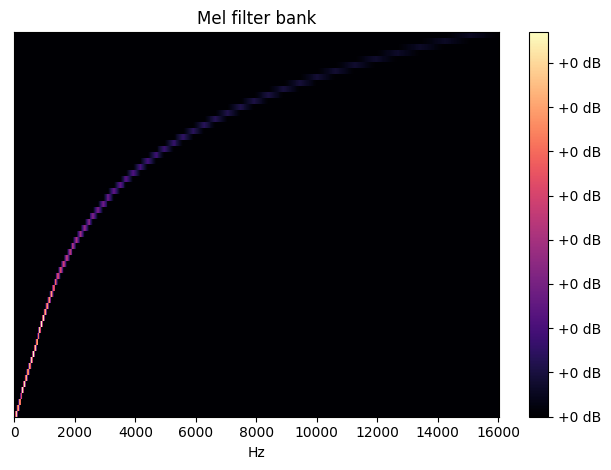

In [14]:
mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=mel_bins, fmin=0.0, fmax=None, htk=False, norm='slaney')
print("The shape of the mel filter bank is: ", mel_filter_bank.shape)
librosa.display.specshow(mel_filter_bank, sr=sr, x_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel filter bank')
plt.tight_layout()
plt.show()